# Regional Analyses

In [2]:
import os
import rasterio as rs
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd 
import pandas as pd

## Create Regional Spreadsheets
Combines country stats spreadsheets into one csv for the region.

In [3]:
def create_regional_csv(list_of_countries, region):
    
    regional_df = pd.DataFrame()
    dfs_to_concat = []
    
    for country in list_of_countries:
        country_df = pd.read_csv(f'{country}/stats/{country}_statistics.csv')
        dfs_to_concat.append(country_df)
    
    regional_df = pd.concat(dfs_to_concat, ignore_index=True)
    regional_df.to_csv(f'regional_stats/{region}.csv', index=False)
    
    return None

In [4]:
create_regional_csv(['Belize', 'El Salvador', 'Guatemala', 'Honduras', 'Nicaragua', 'Panama', 'Costa Rica'], 
                    'central_am')

In [18]:
create_regional_csv(['Rwanda', 'Burundi'], 'east_afr')

## Sampling Area: Country
This barchart illustrates the sampling coverage for each land cover class in a country. Each bar shows the sampled and total hectares of each land cover class in hectares (any hectare containing >0% tree cover is included). The results are sorted by hectares of land cover sampled in ascending order.

In [5]:
def lc_sampled(country):
    
    df = pd.read_csv(f'{country}/stats/{country}_statistics.csv')
    df = df[['country', 'admin', 'esa_class', 'esa_sampled_ha', 'esa_total_ha']]
    
    df = df.drop_duplicates(keep='first', ignore_index=True)
    df['esa_not_sampled'] = df['esa_total_ha'] - df['esa_sampled_ha']
    df = df.groupby(by='esa_class').sum().reset_index()
    df = df.sort_values(by='esa_sampled_ha')
    df = df[['esa_class', 'esa_sampled_ha', 'esa_not_sampled', 'esa_total_ha']]
    df['esa_perc_sampled'] = round((df['esa_sampled_ha'] / df['esa_total_ha']) * 100)

    
    # create the visualization
    plt.figure(figsize=(10,5))
    classes = list(df.esa_class.values)
    bars1 = df.esa_sampled_ha
    bars2 = df.esa_not_sampled

    plt.barh(classes, bars1, color="#f3e151", label='sampled')  
    plt.barh(classes, bars2, left=bars1, color="#6c3376", label='not sampled')

    plt.title(f'Land Cover Sampled in {country}')
    plt.xlabel('Tree Cover (ha)')
    plt.ticklabel_format(useOffset=False, style='plain', axis='x')
    plt.grid(axis='x', linestyle='-', linewidth=.2)
    plt.legend();
    
    return None

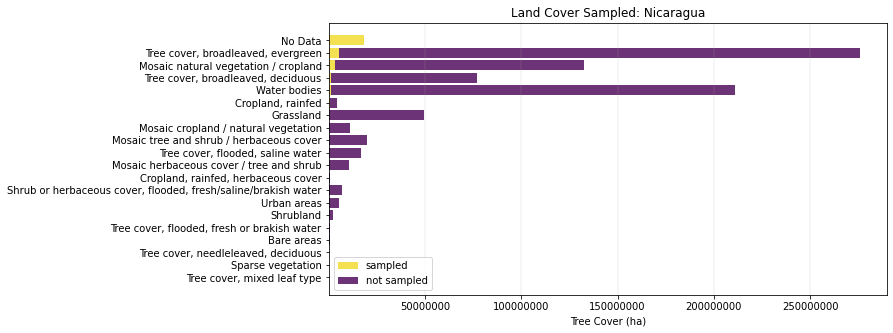

In [25]:
lc_sampled('Nicaragua')

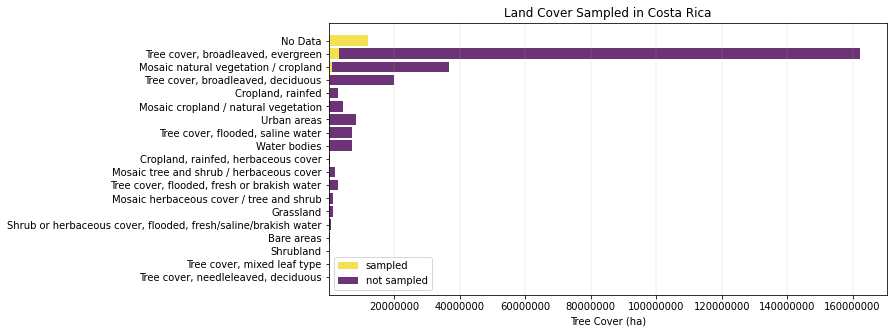

In [6]:
lc_sampled('Costa Rica')

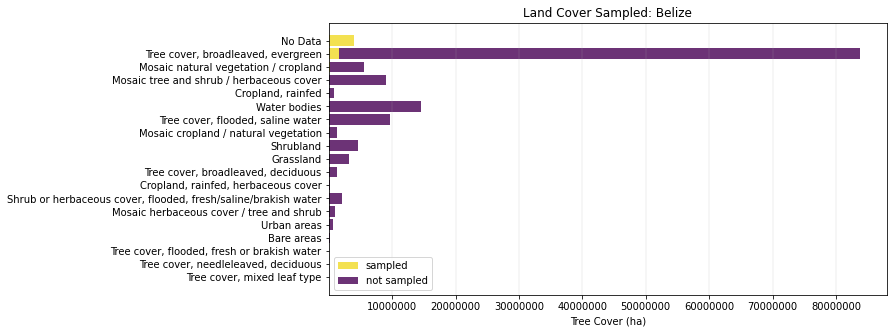

In [26]:
lc_sampled('Belize')

## Top 5 Admins with Trees on Farms
This function returns the top five administrative districts with tree cover on agriculture land cover types.   

It addresses two questions:  
Which admins have the highest mean tree cover in agricultural areas?  
Which admins have the most hectares of tree cover in agricultural areas?  

To compare one admin district to another with unequal sampling we need to account for the % of the sampling area.
- Admin 1: 35%  of farms have >30% cover, 95% of farms sampled. Use the diagram I made above... say we get 32-38% confidence intervals
- Admin 2: 40% of farms have >30% cover, 30% of farms sampled. Here we might have a much wider confidence interval
- Admin 3: No data. No cropland in the admin district. Here we can be confident in the 0% of farms (no farms) having tree cover.



In [9]:
def trees_on_farms(region):
    
    '''
    Filters dataframe to the following ESA agriculture land cover types:
    
    Cropland, rainfed
    Cropland, rainfed, herbaceous cover
    Cropland, irrigated or post-flooding
    Mosaic cropland / natural vegetation
    Mosaic natural vegetation / cropland 
    
    Calculates the total ha tree cover per admin AND the avg % tree cover per admin.
    Merges the dataframes to include % of land cover class sampled and then builds
    two separate dataframes of top 5 cities in the region with highest stats.
    
    '''
    
    df = pd.read_csv(f'regional_stats/{region}.csv')
    
    # filter to only ag land cover classes
    ag_ids = [10.0, 11.0, 20.0, 30.0, 40.0]
    df = df[df.esa_id.isin(ag_ids)]

    # get total (sum) ha tree cover in ag for each admin
    df_ha = df.groupby(by=['country', 'admin']).sum().reset_index() 
    df_ha = df_ha[['country', 'admin', 'esa_sampled_ha', 'esa_total_ha','tof_ha']] 
    
    # add column with % of land cover class that was sampled
    df_ha['esa_perc_samp'] = round((df_ha.esa_sampled_ha / df_ha.esa_total_ha) * 100, 2)

    # now use original dataframe to get average tree cover in ag for each admin
    df_avg = df.groupby(by=['country','admin']).mean().reset_index()
    df_avg = df_avg[['country', 'admin', 'tof_mean']]
    
    # merge dataframes
    df_merged = pd.merge(df_ha, df_avg, how='inner', left_on=['country','admin'], right_on=['country','admin'])
    
    # sort and print top 5 ag areas
    top_5_ha = df_merged.sort_values(['tof_ha', 'esa_perc_samp'], ascending=(False, False))[:5]
    top_5_avg = df_merged.sort_values(['tof_mean', 'esa_perc_samp'], ascending=(False, False))[:5]
    
    print('Top 5 Admins with Trees on Farms (total hectares tree cover)')
    for i in top_5_ha.index:
        print(f'{top_5_ha.esa_perc_samp[i]}% of farms were sampled in {top_5_ha.admin[i]}, ' \
              f'{top_5_ha.country[i]} with {top_5_ha.tof_ha[i]} ha of tree cover >0%.')
    
    print(' ')
    print('Top 5 Admins with Trees on Farms (average % tree cover)')
    for i in top_5_avg.index:
        print(f'{top_5_avg.esa_perc_samp[i]}% of farms were sampled in {top_5_avg.admin[i]}, ' \
              f'{top_5_avg.country[i]} with {round(top_5_avg.tof_mean[i], 0)}% average tree cover.')

    return df_merged

In [10]:
central_am = trees_on_farms('central_am')

Top 5 Admins with Trees on Farms (total hectares tree cover)
3.61% of farms were sampled in Petén, Guatemala with 1807682 ha of tree cover >0%.
2.52% of farms were sampled in Atlántico Sur, Nicaragua with 1243489 ha of tree cover >0%.
2.54% of farms were sampled in Atlántico Norte, Nicaragua with 574631 ha of tree cover >0%.
2.96% of farms were sampled in Veraguas, Panama with 571099 ha of tree cover >0%.
3.01% of farms were sampled in Chontales, Nicaragua with 557226 ha of tree cover >0%.
 
Top 5 Admins with Trees on Farms (average % tree cover)
2.5% of farms were sampled in Ocotepeque, Honduras with 57.0% average tree cover.
2.8% of farms were sampled in El Progreso, Guatemala with 52.0% average tree cover.
3.85% of farms were sampled in Sacatepéquez, Guatemala with 48.0% average tree cover.
2.93% of farms were sampled in Boaco, Nicaragua with 44.0% average tree cover.
2.72% of farms were sampled in Madriz, Nicaragua with 43.0% average tree cover.


## Top 5 Cities with Urban Trees
This function highlights the top five administrative districts in a region with most tree cover in urban land cover types. It addresses two questions:  
Which admins have the highest mean tree cover in urban areas?  
Which admins have the most hectares of tree cover in urban areas?  

In [11]:
def trees_in_cities(region):
    
    '''
    Filters dataframe to the ESA urban land cover class. 
    
    Calculates the total ha tree cover per admin or the comb avg  % tree cover per admin,
    then sorts values in descending order to get top 5 admins.
    
    '''
    
    df = pd.read_csv(f'regional_stats/{region}.csv')
    
    # filter to only urban land cover class
    df = df[df.esa_id == 190.0]
    
    # get total (sum) ha tree cover in urban class for each admin
    df_ha = df.groupby(by=['country', 'admin']).sum().reset_index() 
    df_ha = df_ha[['country', 'admin', 'esa_sampled_ha', 'esa_total_ha','tof_ha']] 
    
    # add column with % of land cover class that was sampled
    df_ha['esa_perc_samp'] = round((df_ha.esa_sampled_ha / df_ha.esa_total_ha) * 100, 2)

    # now use original dataframe to get average tree cover in urban class for each admin
    df_avg = df.groupby(by=['country','admin']).mean().reset_index()
    df_avg = df_avg[['country', 'admin', 'tof_mean']]
    
    # merge dataframes
    df_merged = pd.merge(df_ha, df_avg, how='inner', left_on=['country','admin'], right_on=['country','admin'])
    
    # sort and print top 5 urban areas
    top_5_ha = df_merged.sort_values(['tof_ha', 'esa_perc_samp'], ascending=(False, False))[:5]
    top_5_avg = df_merged.sort_values(['tof_mean', 'esa_perc_samp'], ascending=(False, False))[:5]
    
    # take the top 5 admins/countries and import the tof rasters
    
    # figure out where in that admin has the highest tree cover by lat/lon coordinates?
    # long term could scale down to admin 2 level in these areas?
    
    print('Top 5 Cities with Trees (total hectares tree cover)')
    for i in top_5_ha.index:
        print(f'{top_5_ha.esa_perc_samp[i]}% of urban areas were sampled in {top_5_ha.admin[i]}, ' \
              f'{top_5_ha.country[i]} with {top_5_ha.tof_ha[i]} ha of tree cover >0%.')
    
    print(' ')
    print('Top 5 Cities with Trees (average % tree cover)')
    for i in top_5_avg.index:
        print(f'{top_5_avg.esa_perc_samp[i]}% of urban areas were sampled in {top_5_avg.admin[i]}, ' \
              f'{top_5_avg.country[i]} with {round(top_5_avg.tof_mean[i], 0)}% average tree cover.')

    return df_merged

In [12]:
central_am_cities = trees_in_cities('central_am')

Top 5 Cities with Trees (total hectares tree cover)
0.53% of urban areas were sampled in Guatemala, Guatemala with 30657 ha of tree cover >0%.
0.53% of urban areas were sampled in San José, Costa Rica with 19667 ha of tree cover >0%.
0.53% of urban areas were sampled in Panamá, Panama with 17391 ha of tree cover >0%.
0.53% of urban areas were sampled in Quezaltenango, Guatemala with 16388 ha of tree cover >0%.
0.53% of urban areas were sampled in Cortés, Honduras with 15108 ha of tree cover >0%.
 
Top 5 Cities with Trees (average % tree cover)
0.53% of urban areas were sampled in Usulután, El Salvador with 36.0% average tree cover.
0.53% of urban areas were sampled in Madriz, Nicaragua with 36.0% average tree cover.
0.53% of urban areas were sampled in El Progreso, Guatemala with 34.0% average tree cover.
0.53% of urban areas were sampled in La Libertad, El Salvador with 33.0% average tree cover.
0.53% of urban areas were sampled in San Salvador, El Salvador with 32.0% average tree cov

## Ag/Urban Areas Meeting Forest Cover Definition (>10%)
The FAO defines Forest as a land area of more than 0.5 ha, with a tree canopy cover of more than 10%, which is not primarily under agricultural or other specific non-forest land use. This visualization illustrates the total number of hectares of tree cover that fall above 10% in agriculture and urban land cover classes.

In [13]:
def forest_cover_compliant(region, figsize):
    
    region_df = pd.read_csv(f'regional_stats/{region}.csv')
    
    countries = list(set(region_df.country.values))

    labels = []
    bar1 = []
    bar2 = []

    for country in countries:
        
        # filter to one country and only urban/ag land cover classes
        country_df = region_df[region_df.country == country]
        ids = [10.0, 11.0, 20.0, 30.0, 40.0, 190.0]
        country_df = country_df[country_df.esa_id.isin(ids)]
        
        # get total tof ha per tree cover threshold
        country_df = country_df.groupby(by=['country', 'tree_cover_class']).sum().reset_index() 
        country_df = country_df[['country', 'tree_cover_class', 'tof_ha']] 
        
        # calculate # ha <10% tree cover and >10% tree cover
        under10 = country_df.tof_ha[0]
        over10 = sum(country_df.tof_ha[1:])
        
        labels.append(country)
        bar1.append(under10)
        bar2.append(over10)
    
    plt.figure(figsize=figsize)
    plt.bar(labels, bar1, color="#f3e151", label='<10% cover')  
    plt.bar(labels, bar2, bottom=bar1, color="#6c3376", label='>10% cover')    
    plt.xlabel('Country')
    plt.ylabel('Tree Cover (ha)')
    plt.ticklabel_format(style='plain', axis='y')
    plt.title(f'Ag & Urban Forests \n with >10% Tree Cover')
    plt.legend(); 

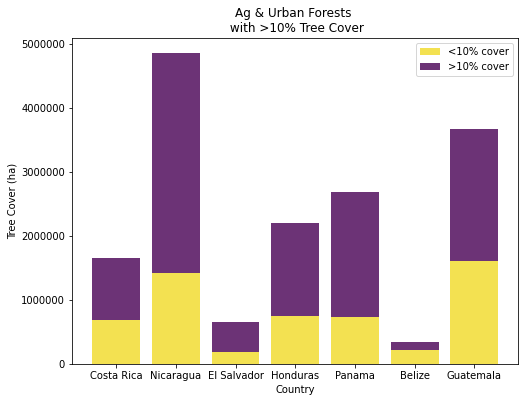

In [14]:
forest_cover_compliant('central_am', (8,6))

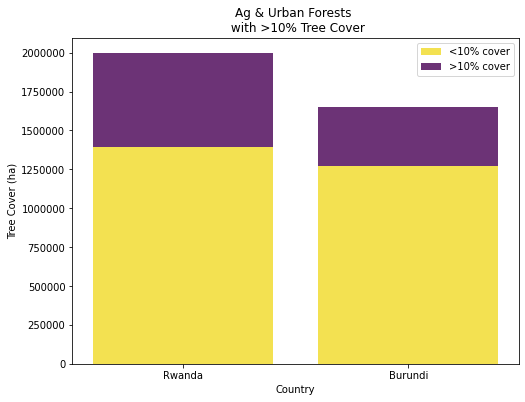

In [15]:
forest_cover_compliant('east_afr', (8,6))

## Top 5 Admins with Fragmented Forests
Clarification: admins with the most fragmented forests? What are we actually calculating?
- fragmented forest: the area of forest within one pixel of the edge
- forest connectivity: the area of disconnected forest fragments

Could replicate the approach used by [Cunningham et al. 2020](https://www.mdpi.com/2072-4292/12/19/3226/htm) and use the Guidos Toolbox [MSPA (Morphological Spatial Pattern Analysis)](https://forest.jrc.ec.europa.eu/en/activities/lpa/mspa/)
- Soille P, Vogt P, 2009. Morphological segmentation of binary patterns. Pattern Recognition Letters 30, 4:456-459, DOI: 10.1016/j.patrec.2008.10.015 

OpenForis example implementation in Python: https://github.com/openforis/mspa-analysis/blob/master/scripts/mspa.py

## Tree Cover Distribution: Regional Comparisons
This grouped barchart compares tree cover distribution in 10% canopy cover thresholds across four regions: Central America, East Africa, West Africa, Sahel). (In the future could consider a facet grid that illustrates the distribution in a barchart per country)

In [19]:
def tree_cover_distribution(central_am, east_afr):
    
    # later will be updated to compare across 4 regions
    #central_am = pd.read_csv('regional_stats/central_am.csv')
    #east_afr = pd.read_csv('regional_stats/east_afr.csv')
    #west_afr = pd.read_csv('regional_stats/west_afr.csv')
    #sahel = pd.read_csv('regional_stats/sahel.csv')

    central_am = central_am.groupby(by=['tree_cover_class']).sum().reset_index() 
    central_am = central_am[['tree_cover_class', 'tof_ha']]

    east_afr = east_afr.groupby(by=['tree_cover_class']).sum().reset_index() 
    east_afr = east_afr[['tree_cover_class', 'tof_ha']]

    labels = list(central_am.tree_cover_class)
    x = np.arange(len(labels))  # the label locations
    width = 0.35  

    plt.figure(figsize=(10,8))
    plt.bar(x - width/2, central_am.tof_ha, width, label='Central America')
    plt.bar(x + width/2, east_afr.tof_ha, width, label='East Africa')

    plt.title('Tree Cover Distribution by Region')
    plt.xlabel('Thresholds (%)')
    plt.ylabel('Total Ha')
    plt.xticks(x, labels=labels)
    plt.ticklabel_format(style='plain', axis='y')
    plt.grid(axis='y', linestyle='-', linewidth=.2)
    plt.legend();
    
    return None

In [20]:
central_am = pd.read_csv('regional_stats/central_am.csv')
east_afr = pd.read_csv('regional_stats/east_afr.csv')

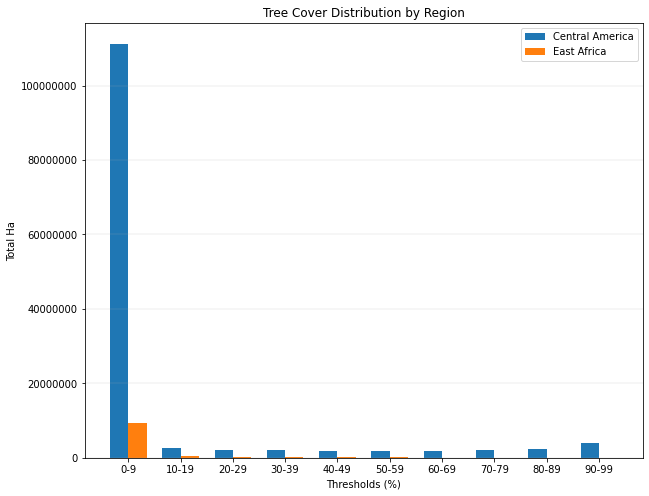

In [21]:
tree_cover_distribution(central_am, east_afr)